# FR Wikipedia Newcomer Experiment Analysis 2020
Julia Kamin and J. Nathan Matias

* [Pre-analysis plan](https://osf.io/g8vrw/)
* [Lab Notebook](https://docs.google.com/document/d/1mNMqYsE6w0OPG9eoSc7rsrMHxeoBqwGJZFiz_tepY8E/edit)
* [Datafile description](https://docs.google.com/document/d/1YCsWf2G89ABSyE3MMB5bWqaSyOkvvYp2IPwBkI1mlMs/edit)
* Datafile: ~/Tresors/CivilServant/projects/wikipedia-integration/fr-newcomer-study/datasets/post-experiment/frwiki-welcome-post-treatment-vars.csv

The study was fielded between January 30, 2020 and May 10, 2020, for a total of 101 days.

In [59]:
## Load Libraries
library(ggplot2)
library(ggpubr)  # contains ggarrange
library(gmodels) # contains CrossTable
library(estimatr)
library(corrplot)
library(lme4)
library(broom)
library(knitr)
library(lmerTest)
library(texreg)
library(stringr)
library(png)
library(MASS)
library(grid)
library(gridExtra)



### Add Source Sans as a font for ggplot2
library(sysfonts) # to load source sans pro
# https://rdrr.io/github/kjhealy/sourcesans/src/R/sourcesans.r

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]))



end.caption.text = "

Citizens & Technology Lab - citizensandtech.org
© Creative Commons International Attribution 4.0"

## Loading and setting up data for analysis

In [60]:
data.dir = "~/Tresors/CivilServant/projects/wikipedia-integration/fr-newcomer-study/datasets/post-experiment/"
filename = "frwiki-welcome-post-treatment-vars.csv"
participants <- read.csv(paste(data.dir, filename, sep=""),  na.string = "" )

In [61]:
cat.logo.filename <- "../../assets/CAT-Logo-Horizontal-social-media-preview-color.png"
logo.img <- readPNG(cat.logo.filename)
logo.pngob <- rasterGrob(logo.img)

### Identify and remove incomplete blocks

In [62]:
participants$counter <- 1
block.sizes <- aggregate(participants[c("counter")], by=list(participants$randomization.block.id), FUN=sum)
incomplete.blocks <- subset(block.sizes, counter!=6)$Group.1
print(paste("Removing the following block for being incomplete:", incomplete.blocks))
removed.participants <- subset(participants, (randomization.block.id %in% c(incomplete.blocks)))
participants <- subset(participants, (randomization.block.id %in% c(incomplete.blocks))!=TRUE)


[1] "Removing the following block for being incomplete: 1"   
[2] "Removing the following block for being incomplete: 9516"


### Set up Variables

In [63]:
# create variable for each treatment arm
participants$control = ifelse(participants$randomization.arm == 0, 1, 0)
participants$treat.one = ifelse(participants$randomization.arm == 1, 1, 0)
participants$treat.two = ifelse(participants$randomization.arm == 2, 1, 0)

In [64]:
participants$labor.minutes <- round(participants$labor.hours.nontruncated*60)

In [65]:
participants$survey.consent = ifelse(participants$survey.consent == NA, 0, 1)

In [66]:
# transform variables to numerics
participants$seven.day.activation = ifelse(participants$seven.day.activation == "True", 1, 0)
participants$four.week.retention = ifelse(participants$four.week.retention == "True", 1, 0)
participants$mentor.respond = ifelse(participants$mentor.respond == "True", 1, 0)
participants$forum.des.nouveaux = ifelse(participants$forum.des.nouveaux == "True", 1, 0)
participants$social.response = ifelse(participants$social.response == "True", 1, 0)
participants$sandbox = ifelse(participants$sandbox == "True", 1, 0)

In [67]:
# change variable name
participants$community.friendliness = participants$friendliness

In [68]:
# create subset of survey compliers
complier.participants = subset(participants, complier == 1)

In [69]:
colnames(participants)

[1] "private.anonymous.id"               "seven.day.activation"              
 [3] "labor.hours"                        "efficacy"                          
 [5] "friendliness"                       "four.week.retention"               
 [7] "labor.hours.nontruncated"           "mentor.respond"                    
 [9] "forum.des.nouveaux"                 "social.response"                   
[11] "sandbox"                            "help"                              
[13] "role"                               "trust"                             
[15] "close.community"                    "close.individuals.1"               
[17] "close.individuals.2"                "close.individuals.3"               
[19] "randomization.arm"                  "randomization.block.id"            
[21] "control.accidentally.treated"       "failed.to.treat"                   
[23] "failed.to.treat.already.created"    "failed.to.treat.blocked"           
[25] "block.failed.to.treat"              "block.control.accidentally.treated"
[27] "survey.invitation"                  "complier"                          
[29] "survey.consent"                     "manipulation.check"                
[31] "lang"                               "user.registration"                 
[33] "counter"                            "control"                           
[35] "treat.one"                          "treat.two"                         
[37] "labor.minutes"                      "community.friendliness"

In [70]:
summary(participants)

                           private.anonymous.id seven.day.activation
 0001d563-ee56-5fdf-8b0e-06a28487cfa5:    1     Min.   :0.00        
 0001f81a-b61e-5179-bc7c-fb7ee6d55bce:    1     1st Qu.:0.00        
 0002e13a-476a-5e3f-a3c9-030041435cdc:    1     Median :0.00        
 00030bfd-2e1d-5012-b8f1-43b0b9b4d73c:    1     Mean   :0.37        
 0003be2d-a874-59c0-a998-b95e4858487c:    1     3rd Qu.:1.00        
 000487e1-d47c-5db1-a1d8-03f063c0d046:    1     Max.   :1.00        
 (Other)                             :57078                         
  labor.hours          efficacy      friendliness   four.week.retention
 Min.   :  0.0000   Min.   :1.00    Min.   :1.00    Min.   :0.00000    
 1st Qu.:  0.0000   1st Qu.:3.00    1st Qu.:3.00    1st Qu.:0.00000    
 Median :  0.0000   Median :4.00    Median :4.00    Median :0.00000    
 Mean   :  0.2583   Mean   :3.85    Mean   :3.58    Mean   :0.04408    
 3rd Qu.:  0.0000   3rd Qu.:5.00    3rd Qu.:4.00    3rd Qu.:0.00000    
 Max.   :520.000

## Summary Statistics

In [317]:
accounts.per.day <- nrow(participants)/101
print(paste(as.integer(accounts.per.day), "accounts per day"))
seven.day.activation.control <- round(mean(subset(participants, randomization.arm==0)$seven.day.activation)*100)
print(paste(seven.day.activation.control, "% make one edit by the 7th day", sep=""))
four.week.retention.control <- round(mean(subset(participants, randomization.arm==0)$four.week.retention)*100)
print(paste(four.week.retention.control, "% are still active contributors after 4 weeks", sep=""))


[1] "565 accounts per day"
[1] "37% make one edit by the 7th day"
[1] "4% are still active contributors after 4 weeks"


#participants$four.week.retention

### Create Dataframe for storing p values

In [71]:
p.values <- data.frame("model"=character(),  "p.value"= double(), "adjusted.value"=double())

## Main Outcomes

In [72]:
aggregate(participants[c("seven.day.activation")], 
          by = list(participants$randomization.arm), 
                    FUN=mean)

Group.1,seven.day.activation
0,0.3685621
1,0.3714526
2,0.3700336


In [73]:
# main outcome: 7 day activation
# Treatment 1 -> model.1, Treatment 2 -> model.2
model.1 = difference_in_means(seven.day.activation ~ treat.one, 
                              data =subset(participants, treat.two==0))
model.2 = difference_in_means(seven.day.activation ~ treat.two, data =subset(participants, control==0))
print("7 day activation: Treatment 1 compared to Control")
summary(model.1)
print("7 day activation: Treatment 2 compared to Treatment 1")
summary(model.2)

p.values <- rbind(p.values,
                data.frame("model" = c("model.1", "model.2"), 
                           "pvalue"=c(summary(model.1)$coefficients['treat.one',]['Pr(>|t|)'],
                                      summary(model.2)$coefficients['treat.two',]['Pr(>|t|)']))
                 )

[1] "7 day activation: Treatment 1 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.002890477,0.00494995,0.5839407,0.5592637,-0.006811555,0.01259251,38053.9


[1] "7 day activation: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.001418962,0.004951992,-0.2865436,0.7744634,-0.011125,0.008287073,38053.98


### Labor Hours

In [74]:
# ggplot(participants, aes(labor.hours, fill=randomization.arm)) +
#     geom_histogram(binwidth=1) +
#     facet_grid(randomization.arm ~ 1)
#tail(sort(participants$labor.hours.nontruncated))


## estimate base rates for reporting
summary(baserate.lm <- glm.nb(labor.minutes ~ factor(randomization.arm), data=participants))
predict(baserate.lm, data.frame(randomization.arm=c(0,1,2)), type="response", se.fit=TRUE)


Call:
glm.nb(formula = labor.minutes ~ factor(randomization.arm), data = participants, 
    init.theta = 0.09179498313, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0069  -1.0005  -0.9959  -0.2730  16.3221  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 3.13040    0.02398 130.568  < 2e-16 ***
factor(randomization.arm)1 -0.07009    0.03391  -2.067 0.038729 *  
factor(randomization.arm)2 -0.12093    0.03391  -3.566 0.000362 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0918) family taken to be 1)

    Null deviance: 42652  on 57083  degrees of freedom
Residual deviance: 42639  on 57081  degrees of freedom
AIC: 282704

Number of Fisher Scoring iterations: 1


              Theta:  0.091795 
          Std. Err.:  0.000699 

 2 x log-likelihood:  -282695.738000 

$fit
       1        2        3 
22.88317 21.33419 20.27670 

$se.fit
        1         2         3 
0.5486300 0.5115669 0.4862639 

$residual.scale
[1] 1

In [238]:
# main outcome: labor Minutes

# Treatment 1 -> model.3, Treatment 2 -> model.4
model.3 = glm.nb(labor.minutes ~ treat.one, data = subset(participants,treat.two==0))
model.4 = glm.nb(labor.minutes ~ treat.two, data = subset(participants,control==0))
print("Labor Minutes: Treatment 1 compared to Control")
summary(model.3)
print("Labor Minutes: Treatment 2 compared to Treatment 1")
summary(model.4)

[1] "Labor Minutes: Treatment 1 compared to Control"



Call:
glm.nb(formula = labor.minutes ~ treat.one, data = subset(participants, 
    treat.two == 0), init.theta = 0.09098893265, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0033  -1.0033  -0.9969  -0.2828  16.2504  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.13040    0.02408 129.996   <2e-16 ***
treat.one   -0.07009    0.03406  -2.058   0.0396 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.091) family taken to be 1)

    Null deviance: 28415  on 38055  degrees of freedom
Residual deviance: 28411  on 38054  degrees of freedom
AIC: 188681

Number of Fisher Scoring iterations: 1


              Theta:  0.090989 
          Std. Err.:  0.000847 

 2 x log-likelihood:  -188675.210000 

[1] "Labor Minutes: Treatment 2 compared to Treatment 1"



Call:
glm.nb(formula = labor.minutes ~ treat.two, data = subset(participants, 
    control == 0), init.theta = 0.09285682565, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0053  -1.0053  -1.0006  -0.2746  16.4160  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.06031    0.02384 128.359   <2e-16 ***
treat.two   -0.05084    0.03372  -1.508    0.132    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0929) family taken to be 1)

    Null deviance: 28469  on 38055  degrees of freedom
Residual deviance: 28467  on 38054  degrees of freedom
AIC: 188349

Number of Fisher Scoring iterations: 1


              Theta:  0.092857 
          Std. Err.:  0.000867 

 2 x log-likelihood:  -188343.183000 

In [76]:
p.values <- rbind(p.values,
                data.frame("model" = c("model.3", "model.4"), 
                           "pvalue"=c(summary(model.3)$coefficients['treat.one',]['Pr(>|z|)'],
                                      summary(model.4)$coefficients['treat.two',]['Pr(>|z|)']))
                 )

## Create Charts of Results

### Differences in Means

In [234]:
model.1.df <- data.frame(summary(model.1))
m.1.plot <- ggplot(model.1.df, aes("Welcome Message\ncompared to\nNo Welcome", coefficients.Estimate)) +
    geom_hline(yintercept = 0, linetype="dashed", color="#999999") +    
    geom_point(color=chartpalette[1]) +
    geom_errorbar(aes(ymax=model.1.df$coefficients.CI.Upper, 
                      ymin=model.1.df$coefficients.CI.Lower), 
                  size=1, color=chartpalette[1], width=0.15) +
    ylab("Estimated effect on 7 Day Activation") +
    ylim(-0.02, 0.02) +
    cat.theme +
    theme(axis.title.x=element_blank())
    

model.2.df <- data.frame(summary(model.2))
m.2.plot <- ggplot(model.2.df, aes("Welcome + Mentorship Button\ncompared to\nWelcome Message", coefficients.Estimate)) +
    geom_hline(yintercept = 0, linetype="dashed", color="#999999") +    
    geom_point(color=chartpalette[2]) +
    geom_errorbar(aes(ymax=model.2.df$coefficients.CI.Upper, 
                      ymin=model.2.df$coefficients.CI.Lower), 
                  size=1, color=chartpalette[2], width=0.15) +
    ylab("Estimated effect") +
    ylim(-0.02, 0.02) +
    cat.theme +
    theme(axis.title.x=element_blank(), axis.title.y=element_blank())

In [330]:
blog.plot <- ggarrange(m.1.plot, m.2.plot,ncol=2, nrow=1, widths=c(1,1))

plot.title <- paste("7-Week activation rates were not measurably different between the welcome message \n",
                    "and (a) the control group or (b) the welcome message with a mentorship button", sep="")
                    
plot.caption <- paste("Intent to treat difference in means estimates for a field experiment with the French language Wikipedia.\n",
                      "New accounts (n=", prettyNum(nrow(participants), big.mark = ","), 
                      ") were randomly assigned to receive no welcome, a welcome message, and a\n",
                      "welcome message with an offer of mentorship. Outcome: whether an account made at least one edit\n",
                      "within seven days after being assigned.",
                      end.caption.text,
                      sep="")

x.just = 0
h.just = 0

blog.plot <- 
    annotate_figure(blog.plot,
        top=text_grob(plot.title,
        hjust=h.just, x=x.just, size=12,
        face="bold",
        color=chartpalette[2]),
        bottom=text_grob(plot.caption, 
        hjust=h.just, x=x.just, size=10, 
        color=chartpalette[4])) +
        annotation_custom(logo.pngob, ymin=-0.90, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just))

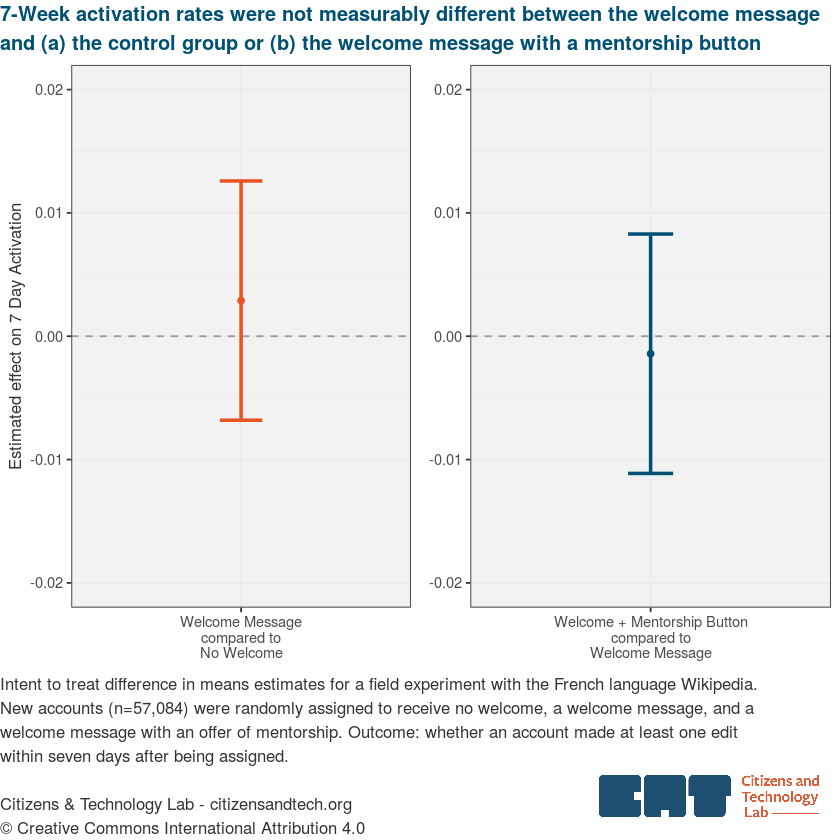

In [331]:
blog.plot

In [347]:
m.1.plot.fr <- ggplot(model.1.df, aes("Message d'accueil versus pas de message d'accueil", coefficients.Estimate)) +
    geom_hline(yintercept = 0, linetype="dashed", color="#999999") +    
    geom_point(color=chartpalette[1]) +
    geom_errorbar(aes(ymax=model.1.df$coefficients.CI.Upper, 
                      ymin=model.1.df$coefficients.CI.Lower), 
                  size=1, color=chartpalette[1], width=0.15) +
    ylab("Effet estimé sur le taux d'activation à 7 jours") +
    ylim(-0.02, 0.02) +
    cat.theme +
    theme(axis.title.x=element_blank())
    

m.2.plot.fr <- ggplot(model.2.df, aes("Message d'accueil + bouton mentorat\nversus message d'accueil", coefficients.Estimate)) +
    geom_hline(yintercept = 0, linetype="dashed", color="#999999") +    
    geom_point(color=chartpalette[2]) +
    geom_errorbar(aes(ymax=model.2.df$coefficients.CI.Upper, 
                      ymin=model.2.df$coefficients.CI.Lower), 
                  size=1, color=chartpalette[2], width=0.15) +
    ylab("Effet estimé") +
    ylim(-0.02, 0.02) +
    cat.theme +
    theme(axis.title.x=element_blank(), axis.title.y=element_blank())

blog.plot.fr <- ggarrange(m.1.plot.fr, m.2.plot.fr,ncol=2, nrow=1, widths=c(1,1))

plot.title.fr <- paste("Les taux d'activation à 7 jours ne sont significativement pas différents entre le groupe\n", 
                       "ayant reçu un message d'accueil et le groupe contrôle (a) ou le groupe ayant reçu \nun message d'accueil avec un bouton avec proposition de mentorat (b).", sep="")
                    
plot.caption.fr <- paste("Différences d'intention de traiter (en moyenne) pour une expérience en condition réelle auprès de Wikipédia\n",
                         "en français. Les nouveaux comptes (n = 57084) ont été assignés aléatoirement à un des groupes suivants :\n",
                         "pas de message d'accueil, un message d'accueil ou un message d'accueil avec proposition de mentorat.\n",
                         "Résultat : un compte a-t-il fait au moins une contribution dans les 7 jours suivant son affectation au groupe.",
                      end.caption.text,
                      sep="")

x.just = 0
h.just = 0

blog.plot.fr <- 
    annotate_figure(blog.plot.fr,
        top=text_grob(plot.title.fr,
        hjust=h.just, x=x.just, size=12,
        face="bold",
        color=chartpalette[2]),
        bottom=text_grob(plot.caption.fr, 
        hjust=h.just, x=x.just, size=10, 
        color=chartpalette[4])) +
        annotation_custom(logo.pngob, ymin=-0.95, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just))

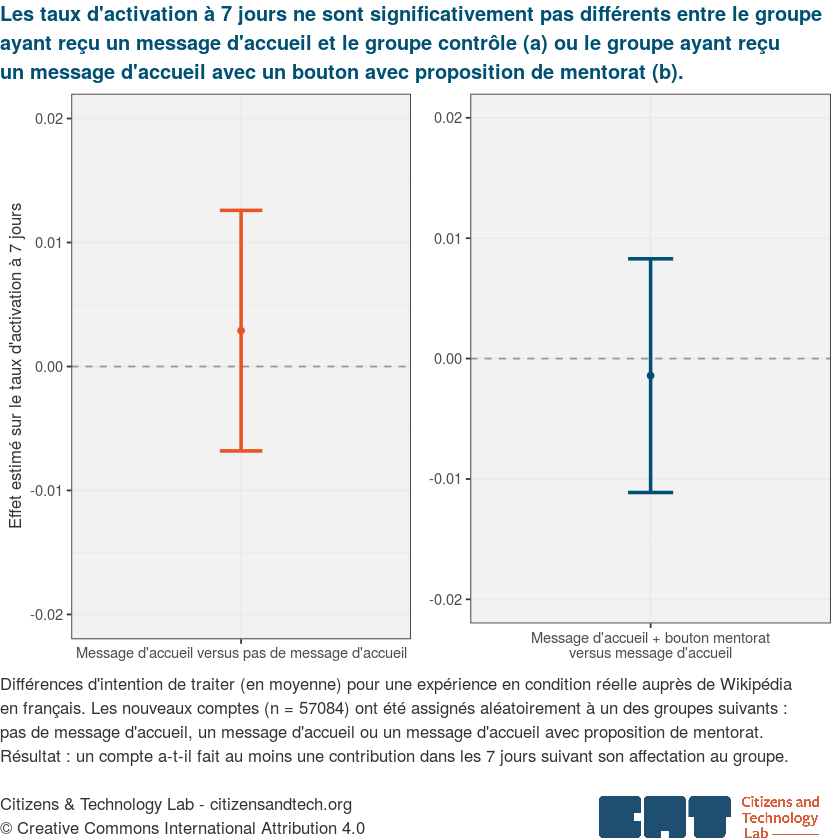

In [348]:
blog.plot.fr

# Exploratory Analyses

In [78]:
# NOT a model in experiment plan, but thought FR liaisons may be interested in this analysis
# main outcome: labor hours
# Treatment 2 compared to Control -> model.5
model.5 = glm.nb(labor.hours ~ treat.two, data = subset(participants,treat.one==0))
print("Treatment 2 compared to Control")
summary(model.5)

[1] "Treatment 2 compared to Control"



Call:
glm.nb(formula = labor.hours ~ treat.two, data = subset(participants, 
    treat.one == 0), init.theta = 0.01989318315, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3288  -0.3288  -0.3193  -0.3193   8.2644  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.26882    0.05319  -23.86   <2e-16 ***
treat.two   -0.16593    0.07544   -2.20   0.0278 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0199) family taken to be 1)

    Null deviance: 5015.6  on 38055  degrees of freedom
Residual deviance: 5010.7  on 38054  degrees of freedom
AIC: 23805

Number of Fisher Scoring iterations: 1


              Theta:  0.019893 
          Std. Err.:  0.000559 

 2 x log-likelihood:  -23799.290000 

In [79]:
# main outcome: efficacy
# Treatment 1 -> model.6, Treatment 2 -> model.7
model.6 = difference_in_means(efficacy ~ treat.one, data =subset(complier.participants, treat.two==0))
model.7 = difference_in_means(efficacy ~ treat.two, data =subset(complier.participants, control==0))
print("Efficacy: Treatment 1 compared to Control")
summary(model.6)
print("Efficacy: Treatment 2 compared to Treatment 1")
summary(model.7)

[1] "Efficacy: Treatment 1 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1142938,0.08953726,1.276494,0.2023125,-0.06157799,0.2901656,557.2259


[1] "Efficacy: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.0413051,0.09676653,-0.4268532,0.6696619,-0.2314038,0.1487936,523.118


In [80]:
# main outcome: reported community friendliness
# Treatment 1 -> model.8, Treatment 2 -> model.9
model.8 = difference_in_means(community.friendliness ~ treat.one, data =subset(complier.participants, treat.two==0))
model.9 = difference_in_means(community.friendliness ~ treat.two, data =subset(complier.participants, control==0))
print("Community friendliness: Treatment 1 compared to Control")
summary(model.8)
print("Community friendliness: Treatment 2 compared to Treatment 1")
summary(model.9)

[1] "Community friendliness: Treatment 1 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1090471,0.09087024,1.200031,0.2306336,-0.06944011,0.2875343,561.3986


[1] "Community friendliness: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.0723707,0.09608753,-0.7531748,0.4516832,-0.2611349,0.1163935,523.8724


In [81]:
summary(model.9)$coefficients['treat.two',][['Pr(>|t|)']]

[1] 0.4516832

In [82]:
# four week retention
# Treatment 1 -> model.10, Treatment 2 -> model.11, Treatment compared to control -> model.12
model.10 = difference_in_means(four.week.retention ~ treat.one, data =subset(participants, treat.two==0))
model.11 = difference_in_means(four.week.retention ~ treat.two, data =subset(participants, control==0))
model.12 = difference_in_means(four.week.retention ~ treat.two, data =subset(participants, treat.one==0))
print("Four week retention: Treatment 1 compared to Control")
summary(model.10)
print("Four week retention: Treatment 2 compared to Treatment 1")
summary(model.11)
print("Four week retention: Treatment 2 compared to Control")
summary(model.12)

[1] "Four week retention: Treatment 1 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,-0.0005780954,0.00210066,-0.2751971,0.7831663,-0.004695444,0.003539253,38052.5


[1] "Four week retention: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.000788312,0.002103055,0.3748414,0.7077805,-0.003333731,0.004910355,38051.22


[1] "Four week retention: Treatment 2 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.0002102165,0.002109634,0.09964598,0.9206259,-0.003924721,0.004345154,38053.81


In [83]:
# labor hours nontruncated
## note: could not run with glm.nb
# Treatment 1 -> model.3, Treatment 2 -> model.4
model.13 = lm(log1p(labor.hours.nontruncated) ~ treat.one, data = subset(participants,treat.two==0))
model.14 = lm(log1p(labor.hours.nontruncated) ~ treat.two, data = subset(participants,control==0))
model.15 = lm(log1p(labor.hours.nontruncated) ~ treat.two, data = subset(participants,treat.one==0))
print("Labor hours nontruncated: Treatment 1 compared to Control")
summary(model.13)
print("Labor hours nontruncated: Treatment 2 compared to Treatment 1")
summary(model.14)
print("Labor hours nontruncated: Treatment 2 compared to Control")
summary(model.15)

[1] "Labor hours nontruncated: Treatment 1 compared to Control"



Call:
lm(formula = log1p(labor.hours.nontruncated) ~ treat.one, data = subset(participants, 
    treat.two == 0))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1384 -0.1384 -0.1368 -0.0240  6.1190 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.138413   0.002566  53.938   <2e-16 ***
treat.one   -0.001605   0.003629  -0.442    0.658    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.354 on 38054 degrees of freedom
Multiple R-squared:  5.14e-06,	Adjusted R-squared:  -2.114e-05 
F-statistic: 0.1956 on 1 and 38054 DF,  p-value: 0.6583


[1] "Labor hours nontruncated: Treatment 2 compared to Treatment 1"



Call:
lm(formula = log1p(labor.hours.nontruncated) ~ treat.two, data = subset(participants, 
    control == 0))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1368 -0.1368 -0.1368 -0.0240  6.1190 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.368e-01  2.536e-03  53.951   <2e-16 ***
treat.two   2.381e-05  3.586e-03   0.007    0.995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3498 on 38054 degrees of freedom
Multiple R-squared:  1.158e-09,	Adjusted R-squared:  -2.628e-05 
F-statistic: 4.408e-05 on 1 and 38054 DF,  p-value: 0.9947


[1] "Labor hours nontruncated: Treatment 2 compared to Control"



Call:
lm(formula = log1p(labor.hours.nontruncated) ~ treat.two, data = subset(participants, 
    treat.one == 0))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1384 -0.1384 -0.1368 -0.0240  6.0830 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.138413   0.002568  53.889   <2e-16 ***
treat.two   -0.001581   0.003632  -0.435    0.663    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3543 on 38054 degrees of freedom
Multiple R-squared:  4.98e-06,	Adjusted R-squared:  -2.13e-05 
F-statistic: 0.1895 on 1 and 38054 DF,  p-value: 0.6633


In [84]:
# Did treatments make newcomers more likely to take and complete the survey?
# Note: tried to run model looking at participants who *started* survey, but variable was all NAs
model.16 = difference_in_means(complier ~ treat.one, data =subset(participants, treat.two==0))
model.17 = difference_in_means(complier ~ treat.two, data =subset(participants, control==0))
model.18 = difference_in_means(complier ~ treat.two, data =subset(participants, treat.one==0))
print("Took survey: Treatment 1 compared to Control")
summary(model.16)
print("Took survey: Treatment 2 compared to Treatment 1")
summary(model.17)
print("Took survey: Treatment 2 compared to Control")
summary(model.18)

[1] "Took survey: Treatment 1 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,-0.02998367,0.0319893,-0.9373032,0.3488839,-0.092776,0.03280866,804.6479


[1] "Took survey: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.022524,0.03355434,0.6712693,0.502252,-0.04334571,0.08839371,763.5309


[1] "Took survey: Treatment 2 compared to Control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.007459677,0.03159678,-0.2360898,0.8134223,-0.06948037,0.05456102,814.6445


In [85]:
# Did treatment 2 make newcomers more likely to contact mentors?
model.19 = difference_in_means(mentor.respond ~ treat.two, data =subset(participants, control==0))
print("Mentor respond: Treatment 2 compared to Treatment 1")
summary(model.19)

[1] "Mentor respond: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.001839395,0.0007053156,2.607903,0.009113571,0.0004569558,0.003221833,36694.51


In [86]:
# Running model above with linear model to see baseline
# NOTE: Not included in adjustment analysis since duplicative of model.19
model.20 = lm(mentor.respond ~ treat.two, data =subset(participants, control==0))
print("Mentor respond: Treatment 2")
summary(model.20)

[1] "Mentor respond: Treatment 2"



Call:
lm(formula = mentor.respond ~ treat.two, data = subset(participants, 
    control == 0))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.00568 -0.00568 -0.00384 -0.00384  0.99616 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0038365  0.0004987   7.692 1.48e-14 ***
treat.two   0.0018394  0.0007053   2.608  0.00911 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0688 on 38054 degrees of freedom
Multiple R-squared:  0.0001787,	Adjusted R-squared:  0.0001524 
F-statistic: 6.801 on 1 and 38054 DF,  p-value: 0.009113


In [87]:
# Did treatment make newcomers more likely to go to forum des nouveaux?
model.21 = difference_in_means(forum.des.nouveaux ~ treat.one, data =subset(participants, treat.two==0))
model.22 = difference_in_means(forum.des.nouveaux ~ treat.two, data =subset(participants, control==0))
model.23 = difference_in_means(forum.des.nouveaux ~ treat.two, data =subset(participants, treat.one==0))
print("Forum des nouveau: Treatment 1")
summary(model.21)
print("Forum des nouveau: Treatment 2 compared to Treatment 1")
summary(model.22)
print("Forum des nouveau: Treatment 2 compared to control")
summary(model.23)

[1] "Forum des nouveau: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.0001051083,0.0007034365,0.1494211,0.8812221,-0.001273646,0.001483862,38049.35


[1] "Forum des nouveau: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.001418962,0.0007576621,1.872816,0.06110161,-6.60769e-05,0.002904,37435.99


[1] "Forum des nouveau: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.00152407,0.0007540424,2.021199,0.04326629,4.612592e-05,0.003002014,37329.17


In [88]:
# Did treatment make newcomers more likely to go to respond to mentor or go to forum des nouveaux?
# NOTE: Only include model.25 in adjustment, since other two compare to control who have no mentors
model.24 = difference_in_means(social.response ~ treat.one, data =subset(participants, treat.two==0))
model.25 = difference_in_means(social.response ~ treat.two, data =subset(participants, control==0))
model.26 = difference_in_means(social.response ~ treat.two, data =subset(participants, treat.one==0))
print("Social response: Treatment 1")
summary(model.24)
print("Social response: Treatment 2 compared to Treatment 1")
summary(model.25)
print("Social response: Treatment 2 compared to control")
summary(model.26)

[1] "Social response: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.003573681,0.0008214282,4.35057,1.361639e-05,0.001963656,0.005183706,35382.83


[1] "Social response: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.002890477,0.001004543,2.877406,0.004011874,0.0009215456,0.004859409,37242.38


[1] "Social response: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.006464158,0.0009075863,7.122362,1.082836e-12,0.004685256,0.00824306,32670.79


In [89]:
# Did treatment make newcomers more likely to go to use the sandbox?
model.27 = difference_in_means(sandbox ~ treat.one, data =subset(participants, treat.two==0))
model.28 = difference_in_means(sandbox ~ treat.two, data =subset(participants, control==0))
model.29 = difference_in_means(sandbox ~ treat.two, data =subset(participants, treat.one==0))
print("Sandbox: Treatment 1")
summary(model.27)
print("Sandbox: Treatment 2 compared to Treatment 1")
summary(model.28)
print("Sandbox: Treatment 2 compared to control")
summary(model.29)

[1] "Sandbox: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,-0.001366407,0.001853944,-0.7370275,0.4611102,-0.005000186,0.002267371,38039.57


[1] "Sandbox: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.001839395,0.001860171,0.9888307,0.3227523,-0.00180659,0.005485379,38028.23


[1] "Sandbox: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.0004729872,0.001878082,0.2518459,0.8011615,-0.003208102,0.004154077,38052.36


In [90]:
# Were newcomers in treatment conditions more likely to say they knew where to get help?
model.30 = difference_in_means(help ~ treat.one, data =subset(complier.participants, treat.two==0))
model.31 = difference_in_means(help ~ treat.two, data =subset(complier.participants, control==0))
model.32 = difference_in_means(help ~ treat.two, data =subset(complier.participants, treat.one==0))
print("Help: Treatment 1")
summary(model.30)
print("Help: Treatment 2 compared to Treatment 1")
summary(model.31)
print("Help: Treatment 2 compared to control")
summary(model.32)

[1] "Help: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1392985,0.1061559,1.312208,0.1899959,-0.06922075,0.3478178,551.4723


[1] "Help: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.02435497,0.1119736,-0.2175063,0.8278985,-0.2443277,0.1956177,523.6224


[1] "Help: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.1149436,0.1056963,1.087489,0.2772822,-0.09266004,0.3225472,567.5905


In [91]:
# Were newcomers in treatment conditions more likely to say they knew what tasks they should do?
model.33 = difference_in_means(role ~ treat.one, data =subset(complier.participants, treat.two==0))
model.34 = difference_in_means(role ~ treat.two, data =subset(complier.participants, control==0))
model.35 = difference_in_means(role ~ treat.two, data =subset(complier.participants, treat.one==0))
print("Role: Treatment 1")
summary(model.33)
print("Role: Treatment 2 compared to Treatment 1")
summary(model.34)
print("Role: Treatment 2 compared to control")
summary(model.35)

[1] "Role: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.07501418,0.09459384,0.7930134,0.4281046,-0.1107864,0.2608147,562.1473


[1] "Role: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.07601527,0.100111,-0.7593096,0.448009,-0.2726838,0.1206532,523.7829


[1] "Role: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.001001092,0.09666049,-0.01035679,0.9917403,-0.1908572,0.1888551,567.2649


In [92]:
# Were newcomers in treatment conditions more likely to agree that other wikipedians trust them?
model.36 = difference_in_means(trust ~ treat.one, data =subset(complier.participants, treat.two==0))
model.37 = difference_in_means(trust ~ treat.two, data =subset(complier.participants, control==0))
model.38 = difference_in_means(trust ~ treat.two, data =subset(complier.participants, treat.one==0))
print("Trust: Treatment 1")
summary(model.36)
print("Trust: Treatment 2 compared to Treatment 1")
summary(model.37)
print("Trust: Treatment 2 compared to control")
summary(model.38)

[1] "Trust: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1617272,0.09094708,1.778256,0.0759135,-0.01691845,0.3403728,550.7173


[1] "Trust: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.04208608,0.09455184,0.4451112,0.6564239,-0.1436627,0.2278348,522.1694


[1] "Trust: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.2038133,0.08895361,2.291231,0.02231144,0.02909902,0.3785275,574.04


In [93]:
# Were newcomers in treatment conditions more likely to feel close to the community?
model.39 = difference_in_means(close.community ~ treat.one, data =subset(complier.participants, treat.two==0))
model.40 = difference_in_means(close.community ~ treat.two, data =subset(complier.participants, control==0))
model.41 = difference_in_means(close.community ~ treat.two, data =subset(complier.participants, treat.one==0))
print("close.community: Treatment 1")
summary(model.39)
print("close.community: Treatment 2 compared to Treatment 1")
summary(model.40)
print("close.community: Treatment 2 compared to control")
summary(model.41)

[1] "close.community: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1113159,0.1256636,0.8858246,0.3760958,-0.1355186,0.3581505,554.9169


[1] "close.community: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.0413051,0.1333716,0.3096994,0.7569127,-0.2207036,0.3033138,523.9975


[1] "close.community: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.152621,0.1268531,1.203133,0.2294288,-0.09654005,0.4017821,565.0755


In [94]:
# Were newcomers in treatment conditions more likely to say they knew individuals in the community?
model.42 = difference_in_means(close.individuals.1 ~ treat.one, data =subset(complier.participants, treat.two==0))
model.43 = difference_in_means(close.individuals.1 ~ treat.two, data =subset(complier.participants, control==0))
model.44 = difference_in_means(close.individuals.1 ~ treat.two, data =subset(complier.participants, treat.one==0))
print("close.individuals.1: Treatment 1")
summary(model.42)
print("close.individuals.1: Treatment 2 compared to Treatment 1")
summary(model.43)
print("close.individuals.1: Treatment 2 compared to control")
summary(model.44)

[1] "close.individuals.1: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1352571,0.1154288,1.17178,0.2417951,-0.09148039,0.3619947,547.4298


[1] "close.individuals.1: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.0205947,0.1253615,0.1642825,0.8695721,-0.2256783,0.2668677,523.8454


[1] "close.individuals.1: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.1558518,0.1178713,1.322221,0.1866419,-0.07567895,0.3873826,552.3619


In [95]:
# Were newcomers in treatment conditions more likely to say they were known by individuals in the community?
model.45 = difference_in_means(close.individuals.2 ~ treat.one, data =subset(complier.participants, treat.two==0))
model.46 = difference_in_means(close.individuals.2 ~ treat.two, data =subset(complier.participants, control==0))
model.47 = difference_in_means(close.individuals.2 ~ treat.two, data =subset(complier.participants, treat.one==0))
print("close.individuals.2: Treatment 1")
summary(model.45)
print("close.individuals.2: Treatment 2 compared to Treatment 1")
summary(model.46)
print("close.individuals.2: Treatment 2 compared to control")
summary(model.47)

[1] "close.individuals.2: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,-0.0695311,0.118232,-0.5880903,0.5567093,-0.3017647,0.1627025,558.6773


[1] "close.individuals.2: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.01183038,0.1258661,-0.09399182,0.9251516,-0.2590947,0.2354339,523.8339


[1] "close.individuals.2: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,-0.08136149,0.120678,-0.6742029,0.5004585,-0.3183946,0.1556717,564.1206


In [96]:
# Were newcomers in treatment conditions more likely to say if they reached out to someone in the community they'd respond?
model.48 = difference_in_means(close.individuals.3 ~ treat.one, data =subset(complier.participants, treat.two==0))
model.49 = difference_in_means(close.individuals.3 ~ treat.two, data =subset(complier.participants, control==0))
model.50 = difference_in_means(close.individuals.3 ~ treat.two, data =subset(complier.participants, treat.one==0))
print("close.individuals.3: Treatment 1")
summary(model.48)
print("close.individuals.3: Treatment 2 compared to Treatment 1")
summary(model.49)
print("close.individuals.3: Treatment 2 compared to control")
summary(model.50)

[1] "close.individuals.3: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1845339,0.1179525,1.564477,0.1182819,-0.04715956,0.4162274,548.8525


[1] "close.individuals.3: Treatment 2 compared to Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.009313896,0.1252873,0.07434028,0.940768,-0.2368135,0.2554413,523.7496


[1] "close.individuals.3: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.1938478,0.1177675,1.646021,0.1003166,-0.03746874,0.4251644,563.9511


In [97]:
# Did newcomers in treatment conditions recall receiving a welcome message?
model.51 = difference_in_means(manipulation.check ~ treat.one, data =subset(complier.participants, treat.two==0))
model.52 = difference_in_means(manipulation.check ~ treat.two, data =subset(complier.participants, treat.one==0))
print("manipulation.check: Treatment 1")
summary(model.51)
print("manipulation.check: Treatment 2 compared to control")
summary(model.52)

[1] "manipulation.check: Treatment 1"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.one,0.1304594,0.03653304,3.570999,0.0003898185,0.05868308,0.2022358,502.3782


[1] "manipulation.check: Treatment 2 compared to control"


,Estimate,Std. Error,t value,Pr(>|t|),CI Lower,CI Upper,DF
treat.two,0.09219148,0.03531545,2.610514,0.009294145,0.02281748,0.1615655,534.8553


#### Comparing the "contact me" message to control on labor minutes

In [98]:
model.53 = glm.nb(labor.minutes ~ treat.two, data=subset(participants, treat.one==0))
summary(model.53)


Call:
glm.nb(formula = labor.minutes ~ treat.two, data = subset(participants, 
    treat.one == 0), init.theta = 0.09155927505, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0059  -1.0059  -0.9948  -0.2727  15.4675  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.13040    0.02401 130.401  < 2e-16 ***
treat.two   -0.12093    0.03395  -3.562 0.000369 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0916) family taken to be 1)

    Null deviance: 28413  on 38055  degrees of freedom
Residual deviance: 28400  on 38054  degrees of freedom
AIC: 188377

Number of Fisher Scoring iterations: 1


              Theta:  0.091559 
          Std. Err.:  0.000855 

 2 x log-likelihood:  -188370.596000 

# Add P Values to List

In [99]:
pvalue.dataframe <- function(model.object, model.name){
    if("treat.one" %in% rownames(summary(model.object)$coefficients)){
        coefficient = "treat.one"
    }else{
        coefficient = "treat.two"
    }
    
    if('Pr(>|t|)' %in% colnames(summary(model.object)$coefficients)){
        p.col = 'Pr(>|t|)'
    }else{
        p.col = 'Pr(>|z|)'
    }
#    print(coefficient)
#    print(p.col)
   return(data.frame("model"=model.name, 
                     "pvalue" = summary(model.object)$coefficients[coefficient,][[p.col]]))
}

In [100]:
p.values

model,pvalue
model.1,0.55926368
model.2,0.77446336
model.3,0.03959087
model.4,0.13163091


In [101]:
all.pvalues <- 
    rbind(
    p.values,
    pvalue.dataframe(model.5, "model.5"),
    pvalue.dataframe(model.6, "model.6"),
    pvalue.dataframe(model.7, "model.7"),
    pvalue.dataframe(model.8, "model.8"),
    pvalue.dataframe(model.9, "model.9"),
    pvalue.dataframe(model.10, "model.10"),
    pvalue.dataframe(model.11, "model.11"),
    pvalue.dataframe(model.12, "model.12"),
    pvalue.dataframe(model.13, "model.13"),
    pvalue.dataframe(model.14, "model.14"),
    pvalue.dataframe(model.15, "model.15"),
    pvalue.dataframe(model.16, "model.16"),
    pvalue.dataframe(model.17, "model.17"),
    pvalue.dataframe(model.18, "model.18"),
    pvalue.dataframe(model.19, "model.19"),
    pvalue.dataframe(model.21, "model.21"),
    pvalue.dataframe(model.22, "model.22"),
    pvalue.dataframe(model.23, "model.23"),
    pvalue.dataframe(model.25, "model.25"),
    pvalue.dataframe(model.27, "model.27"),
    pvalue.dataframe(model.28, "model.28"),
    pvalue.dataframe(model.29, "model.29"),
    pvalue.dataframe(model.30, "model.30"),
    pvalue.dataframe(model.31, "model.31"),
    pvalue.dataframe(model.32, "model.32"),
    pvalue.dataframe(model.33, "model.33"),
    pvalue.dataframe(model.34, "model.34"),
    pvalue.dataframe(model.35, "model.35"),
    pvalue.dataframe(model.36, "model.36"),
    pvalue.dataframe(model.37, "model.37"),
    pvalue.dataframe(model.38, "model.38"),
    pvalue.dataframe(model.39, "model.39"),
    pvalue.dataframe(model.40, "model.40"),
    pvalue.dataframe(model.41, "model.41"),
    pvalue.dataframe(model.42, "model.42"),
    pvalue.dataframe(model.43, "model.43"),
    pvalue.dataframe(model.44, "model.44"),
    pvalue.dataframe(model.45, "model.45"),
    pvalue.dataframe(model.46, "model.46"),
    pvalue.dataframe(model.47, "model.47"),
    pvalue.dataframe(model.48, "model.48"),
    pvalue.dataframe(model.49, "model.49"),
    pvalue.dataframe(model.50, "model.50"),
    pvalue.dataframe(model.51, "model.51"),
    pvalue.dataframe(model.52, "model.52"),
    pvalue.dataframe(model.53, "model.53"))
confirmatory.p.values <- p.values

#### Confirmatory P Value Adjustments

In [102]:
confirmatory.p.values$p.adjusted <- p.adjust(confirmatory.p.values$pvalue, method="holm", n=nrow(confirmatory.p.values))
confirmatory.p.values

model,pvalue,p.adjusted
model.1,0.55926368,1.0000000
model.2,0.77446336,1.0000000
model.3,0.03959087,0.1583635
model.4,0.13163091,0.3948927


#### All P Value Adjustments

In [103]:
all.pvalues$p.adjusted <- p.adjust(all.pvalues$pvalue, method="holm", n=nrow(all.pvalues))
all.pvalues

model,pvalue,p.adjusted
model.1,0.5592636806,1.00000000
model.2,0.7744633632,1.00000000
model.3,0.0395908687,1.00000000
model.4,0.1316309137,1.00000000
model.5,0.0278397269,1.00000000
model.6,0.2023125169,1.00000000
model.7,0.6696618713,1.00000000
model.8,0.2306335580,1.00000000
model.9,0.4516832095,1.00000000
model.10,0.7831663058,1.00000000


## Follow-Up: Complier Average Causal Effect
In this experiment, not everyone ultimately received the intervention we designed:
* (Control.accidentally.treated) Some people were sent a welcome message by third parties
* (failed.to.treat) Some people never received the welcome message, due to software errors

To estimate the actual effect of receiving the intervention, we can calculate the Complier Average Causal Effect (see Gerber & Green chapter 6).

In [104]:
participants$treat.one.received <- participants$treat.one & participants$failed.to.treat=="False"
participants$treat.two.received <- participants$treat.two & participants$failed.to.treat=="False"

In [105]:
CrossTable(participants$treat.one, participants$treat.one.received,
           prop.t=FALSE, prop.r=FALSE, prop.c=FALSE, prop.chisq=FALSE)

CrossTable(participants$treat.two, participants$treat.two.received,
           prop.t=FALSE, prop.r=FALSE, prop.c=FALSE, prop.chisq=FALSE)

CrossTable(participants$control, participants$control.accidentally.treated,
           prop.t=FALSE, prop.r=FALSE, prop.c=FALSE, prop.chisq=FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|-------------------------|

 
Total Observations in Table:  57084 

 
                       | participants$treat.one.received 
participants$treat.one |     FALSE |      TRUE | Row Total | 
-----------------------|-----------|-----------|-----------|
                     0 |     38056 |         0 |     38056 | 
-----------------------|-----------|-----------|-----------|
                     1 |       249 |     18779 |     19028 | 
-----------------------|-----------|-----------|-----------|
          Column Total |     38305 |     18779 |     57084 | 
-----------------------|-----------|-----------|-----------|

 

 
   Cell Contents
|-------------------------|
|                       N |
|-------------------------|

 
Total Observations in Table:  57084 

 
                       | participants$treat.two.received 
participants$treat.two |     FALSE |      TRUE | Row Total | 
-----------------------|---------

In [106]:
#model.1 = difference_in_means(seven.day.activation ~ treat.one, data =subset(participants, treat.two==0))
#model.2 = difference_in_means(seven.day.activation ~ treat.two, data =subset(participants, control==0))


### Seven Day Activation (CACE)

In [107]:
tidy(iv_robust(seven.day.activation ~ treat.one.received | treat.one.received + treat.one, data = subset(participants, treat.two==0)))

term,estimate,std.error,statistic,p.value,conf.low,conf.high,df,outcome
(Intercept),0.37189397,0.003481109,106.8320453,0.0000000,0.36507090,0.37871703,38054,seven.day.activation
treat.one.receivedTRUE,-0.00382325,0.004950219,-0.7723395,0.4399182,-0.01352581,0.00587931,38054,seven.day.activation


In [108]:
tidy(iv_robust(seven.day.activation ~ treat.two.received | treat.two.received + treat.two, data = subset(participants, treat.one==0)))

term,estimate,std.error,statistic,p.value,conf.low,conf.high,df,outcome
(Intercept),0.371594624,0.003481078,106.7469863,0.0000000,0.3647716,0.378417629,38054,seven.day.activation
treat.two.receivedTRUE,-0.004652915,0.004948189,-0.9403269,0.3470559,-0.0143515,0.005045666,38054,seven.day.activation


### Labor Minutes

In [109]:
participants$treat.one.2s.fitted <- fitted.values(lm(treat.one.received ~ treat.one, data=participants))
participants$treat.two.2s.fitted <- fitted.values(lm(treat.two.received ~ treat.two, data=participants))

In [110]:
summary(glm.nb(labor.minutes ~ treat.one.2s.fitted, data=subset(participants, treat.two==0)))


Call:
glm.nb(formula = labor.minutes ~ treat.one.2s.fitted, data = subset(participants, 
    treat.two == 0), init.theta = 0.09098893265, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0033  -1.0033  -0.9969  -0.2828  16.2504  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.13040    0.02408 129.996   <2e-16 ***
treat.one.2s.fitted -0.07102    0.03451  -2.058   0.0396 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.091) family taken to be 1)

    Null deviance: 28415  on 38055  degrees of freedom
Residual deviance: 28411  on 38054  degrees of freedom
AIC: 188681

Number of Fisher Scoring iterations: 1


              Theta:  0.090989 
          Std. Err.:  0.000847 

 2 x log-likelihood:  -188675.210000 

In [242]:
summary(glm.nb(labor.minutes ~ treat.two.2s.fitted, data=subset(participants, treat.one==0)))


Call:
glm.nb(formula = labor.minutes ~ treat.two.2s.fitted, data = subset(participants, 
    treat.one == 0), init.theta = 0.09155927505, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0059  -1.0059  -0.9948  -0.2727  15.4675  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.13040    0.02401 130.401  < 2e-16 ***
treat.two.2s.fitted -0.12249    0.03439  -3.562 0.000369 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0916) family taken to be 1)

    Null deviance: 28413  on 38055  degrees of freedom
Residual deviance: 28400  on 38054  degrees of freedom
AIC: 188377

Number of Fisher Scoring iterations: 1


              Theta:  0.091559 
          Std. Err.:  0.000855 

 2 x log-likelihood:  -188370.596000 

In [243]:
summary(glm.nb(labor.minutes ~ treat.two.2s.fitted, data=subset(participants, control==0)))


Call:
glm.nb(formula = labor.minutes ~ treat.two.2s.fitted, data = subset(participants, 
    control == 0), init.theta = 0.09285682565, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0053  -1.0053  -1.0006  -0.2746  16.4160  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.06031    0.02384 128.359   <2e-16 ***
treat.two.2s.fitted -0.05150    0.03416  -1.508    0.132    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0929) family taken to be 1)

    Null deviance: 28469  on 38055  degrees of freedom
Residual deviance: 28467  on 38054  degrees of freedom
AIC: 188349

Number of Fisher Scoring iterations: 1


              Theta:  0.092857 
          Std. Err.:  0.000867 

 2 x log-likelihood:  -188343.183000 

# Blog Post Descriptives

### Followup analysis of differences in labor minutes among blocks that didn't include extreme values

In [113]:
tail(sort(participants$labor.hours.nontruncated), n=10)
cutoff = 200
extreme.lh.blocks <- unique(subset(participants, labor.hours.nontruncated>cutoff)$randomization.block.id)
print(paste("Cutoff:", cutoff, "labor hours"))
print(paste("Total Participants:", nrow(participants)))
print(paste("Participants in blocks without extreme values:", nrow(subset(participants, 
                                                                          (randomization.block.id %in% extreme.lh.blocks)!=TRUE))))



summary(glm.nb(labor.minutes ~ factor(randomization.arm), data=subset(participants, 
                                                             (randomization.block.id %in% extreme.lh.blocks)!=TRUE)))

[1] 122.5531 129.4742 132.4119 144.2272 148.8733 150.8383 155.9433 269.7272
 [9] 502.4053 520.0369

[1] "Cutoff: 200 labor hours"
[1] "Total Participants: 57084"
[1] "Participants in blocks without extreme values: 57066"



Call:
glm.nb(formula = labor.minutes ~ factor(randomization.arm), data = subset(participants, 
    (randomization.block.id %in% extreme.lh.blocks) != TRUE), 
    init.theta = 0.09357365413, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0045  -1.0037  -1.0010  -0.2692   9.1700  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 3.018137   0.023757 127.044   <2e-16 ***
factor(randomization.arm)1 -0.037600   0.033599  -1.119    0.263    
factor(randomization.arm)2 -0.008482   0.033597  -0.252    0.801    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0936) family taken to be 1)

    Null deviance: 42654  on 57065  degrees of freedom
Residual deviance: 42653  on 57063  degrees of freedom
AIC: 281863

Number of Fisher Scoring iterations: 1


              Theta:  0.093574 
          Std. Err.:  0.000715 

 2 x log-likelihood:

In [252]:
summary(factor(participants$seven.day.activation))

0     1 
35962 21122

In [114]:
# number of participants
print("Number of participants:")
nrow(participants)
# number of survey takers
print("Number who consented to take survey:")
as.data.frame(table(participants$survey.consent))
print("Number who completed survey:")
as.data.frame(table(participants$complier))

[1] "Number of participants:"


[1] 57084

[1] "Number who consented to take survey:"


Freq


[1] "Number who completed survey:"


Var1,Freq
0,377
1,854


Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

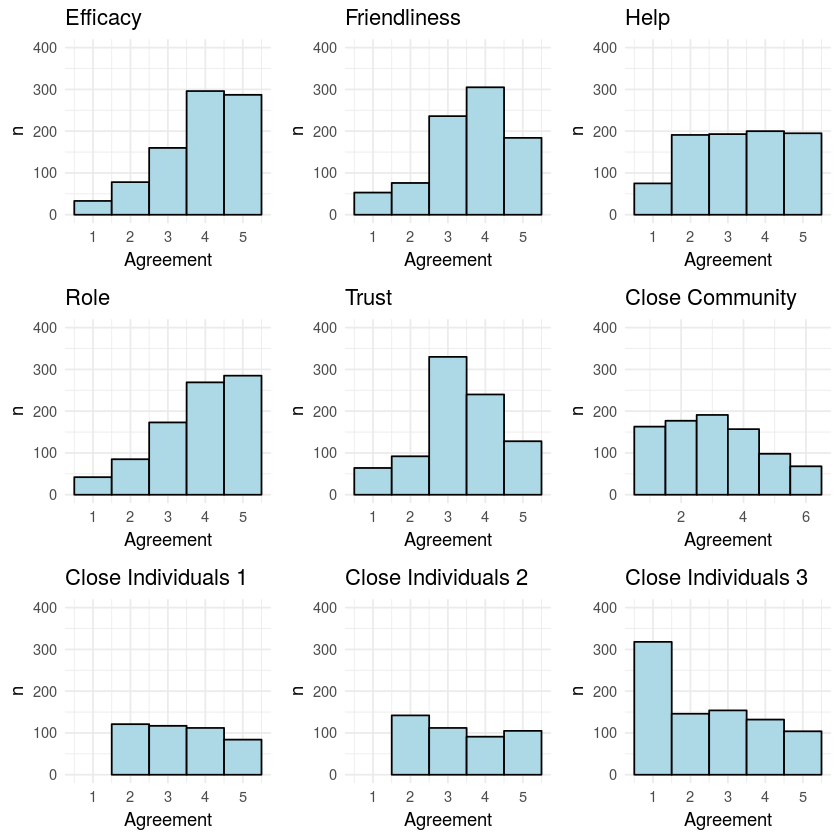

In [245]:
# survey outcome histograms
# hist(complier.participants$efficacy)
plot.efficacy = ggplot(complier.participants, aes(efficacy)) +
    geom_histogram(binwidth=1,color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Efficacy")

plot.friendliness = ggplot(complier.participants, aes(friendliness)) +
    geom_histogram(binwidth=1,color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Friendliness")

plot.help = ggplot(complier.participants, aes(help)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Help")

plot.role = ggplot(complier.participants, aes(role)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Role")

plot.trust = ggplot(complier.participants, aes(trust)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Trust")

plot.close.community = ggplot(complier.participants, aes(close.community)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Close Community")

plot.close.individuals.1 = ggplot(complier.participants, aes(close.individuals.1)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Close Individuals 1")

plot.close.individuals.2 = ggplot(complier.participants, aes(close.individuals.2)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Close Individuals 2")

plot.close.individuals.3 = ggplot(complier.participants, aes(close.individuals.3)) +
    geom_histogram(binwidth=1, color="black", fill="lightblue") +
    theme_minimal() +
    ylim(0,400) +
    labs(x = "Agreement", y = "n") +
    ggtitle("Close Individuals 3")

grid.arrange(plot.efficacy, plot.friendliness, plot.help, 
             plot.role, plot.trust, plot.close.community, 
             plot.close.individuals.1, plot.close.individuals.2, plot.close.individuals.3, ncol=3)

# Aggregate Outcome Measures by Group

In [274]:
participants$study.arm <- factor(participants$randomization.arm)
summary(participants$study.arm)

0     1     2 
19028 19028 19028

In [269]:
colnames(participants)

[1] "private.anonymous.id"               "seven.day.activation"              
 [3] "labor.hours"                        "efficacy"                          
 [5] "friendliness"                       "four.week.retention"               
 [7] "labor.hours.nontruncated"           "mentor.respond"                    
 [9] "forum.des.nouveaux"                 "social.response"                   
[11] "sandbox"                            "help"                              
[13] "role"                               "trust"                             
[15] "close.community"                    "close.individuals.1"               
[17] "close.individuals.2"                "close.individuals.3"               
[19] "randomization.arm"                  "randomization.block.id"            
[21] "control.accidentally.treated"       "failed.to.treat"                   
[23] "failed.to.treat.already.created"    "failed.to.treat.blocked"           
[25] "block.failed.to.treat"              "block.control.accidentally.treated"
[27] "survey.invitation"                  "complier"                          
[29] "survey.consent"                     "manipulation.check"                
[31] "lang"                               "user.registration"                 
[33] "counter"                            "control"                           
[35] "treat.one"                          "treat.two"                         
[37] "labor.minutes"                      "community.friendliness"            
[39] "treat.one.received"                 "treat.two.received"                
[41] "treat.one.2s.fitted"                "treat.two.2s.fitted"               
[43] "treat"

In [302]:
t(aggregate(participants[c("seven.day.activation", "labor.minutes", "four.week.retention",
                         "mentor.respond", "forum.des.nouveaux", "social.response",
                         "sandbox", "help", "role", "trust", "close.community",
                         "community.friendliness",
                         "close.individuals.1", "close.individuals.2", "close.individuals.3",
                        "complier", "manipulation.check")], 
          by = list(participants$randomization.arm), 
                    FUN=mean, na.rm=TRUE))

Group.1,0.000000000,1.000000000,2.000000000
seven.day.activation,0.368562119,0.371452596,0.370033635
labor.minutes,22.883172167,21.334191717,20.276697498
four.week.retention,0.044198024,0.043619929,0.044408240
mentor.respond,0.000000000,0.003836452,0.005675846
forum.des.nouveaux,0.004677318,0.004782426,0.006201387
social.response,0.004677318,0.008250999,0.011141476
sandbox,0.034528064,0.033161657,0.035001051
help,3.222891566,3.348659004,3.328358209
role,3.759036145,3.835249042,3.761194030
trust,3.213855422,3.375478927,3.414179104
